# Stock Forecasting via Deep Learning (LSTM)

1. Problem Setup

We want to predict the next day’s closing stock price.

Let the time series of closing prices be:

$$
\{ P_t \}_{t=1}^T
$$

where $P_t$ is the closing price at day $t$.

Our goal is to forecast:

$$
\hat{P}_{t+1} \quad \text{given} \quad \{P_{t}, P_{t-1}, \dots, P_{t-L+1}\}
$$

where $L$ is the sequence length.

---

2. Naïve Forecasting Method

The **Naïve method** assumes that tomorrow’s price is the same as today’s:

$$
\hat{P}^{\text{naive}}_{t+1} = P_t
$$

---

3. LSTM Forecasting Method

The **LSTM model** learns patterns in historical sequences.

- Input:

$$
X_t = \big(P_{t-L+1}, P_{t-L+2}, \dots, P_t \big)
$$

- The **LSTM network** processes $X_t$ with recurrent dynamics:

$$
h_t, c_t = \text{LSTM}(X_t, h_{t-1}, c_{t-1})
$$

- Output layer:

$$
\hat{P}^{\text{LSTM}}_{t+1} = W h_t + b
$$

where $h_t$ is the hidden state, $c_t$ the cell state, and $W, b$ are trainable parameters.

---

4. Performance Comparison

We evaluate both models using **Root Mean Squared Error (RMSE):**

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \big( P_i - \hat{P}_i \big)^2 }
$$

- **Naïve RMSE:**

$$
\text{RMSE}_{\text{naive}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \big( P_i - P_{i-1} \big)^2 }
$$

- **LSTM RMSE:**

$$
\text{RMSE}_{\text{LSTM}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \big( P_i - \hat{P}^{\text{LSTM}}_i \big)^2 }
$$

---

✅ If

$$
\text{RMSE}_{\text{LSTM}} < \text{RMSE}_{\text{naive}}
$$

then the LSTM has learned useful temporal dependencies beyond the random walk assumption.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 1. Dowload Data

In [2]:
# Download NVDA stock data
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
prices = data['Close'].values.reshape(-1, 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 2. Preprocessing

In [3]:
# Scale prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_prices, SEQ_LEN)

# Train/test split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

## 3. Define the LSTM Model

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 4. Train the Model

In [5]:
EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")


Epoch 100/1000, Loss: 0.000648
Epoch 200/1000, Loss: 0.000524
Epoch 300/1000, Loss: 0.000424
Epoch 400/1000, Loss: 0.000341
Epoch 500/1000, Loss: 0.000296
Epoch 600/1000, Loss: 0.000263
Epoch 700/1000, Loss: 0.000233
Epoch 800/1000, Loss: 0.000207
Epoch 900/1000, Loss: 0.000194
Epoch 1000/1000, Loss: 0.000186


## 5. Evaluation

LSTM RMSE: 2310.92
Naive RMSE: 1868.15


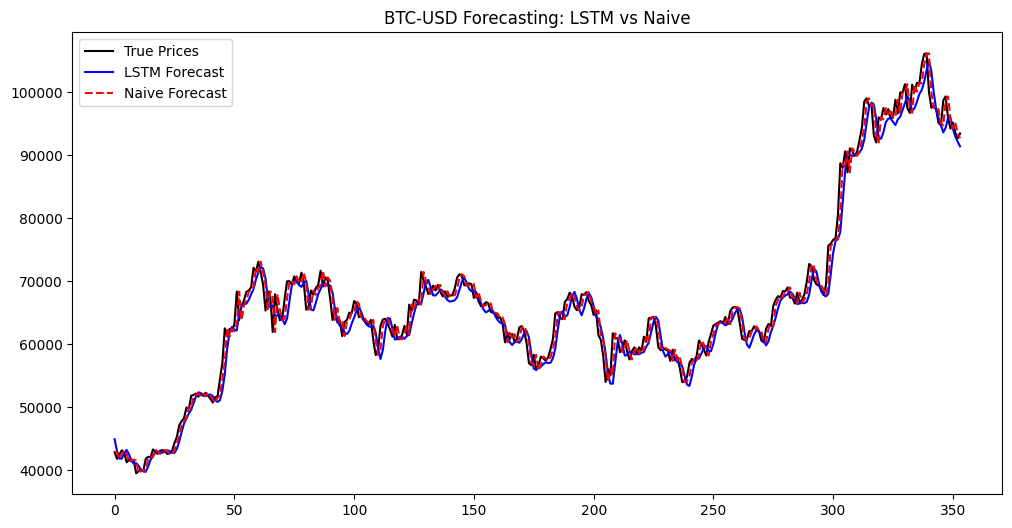

In [6]:
# LSTM prediction
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_test_t).numpy()

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

# Naive prediction: use last observed value in sequence
y_pred_naive = scaler.inverse_transform(X_test[:, -1, :])

# Errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
rmse_naive = np.sqrt(mean_squared_error(y_test_inv, y_pred_naive))

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"Naive RMSE: {rmse_naive:.2f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True Prices", color="black")
plt.plot(y_pred_lstm_inv, label="LSTM Forecast", color="blue")
plt.plot(y_pred_naive, label="Naive Forecast", color="red", linestyle="--")
plt.legend()
plt.title(f"{ticker} Forecasting: LSTM vs Naive")
plt.show()


### Naive Mehtod

$$\hat P_{t+1} = P_t$$

### LSTM

$$\hat P_{t+1} = LSTM[\{P_t, P_{t-1},\ldots,P_{t-n}\}]$$

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

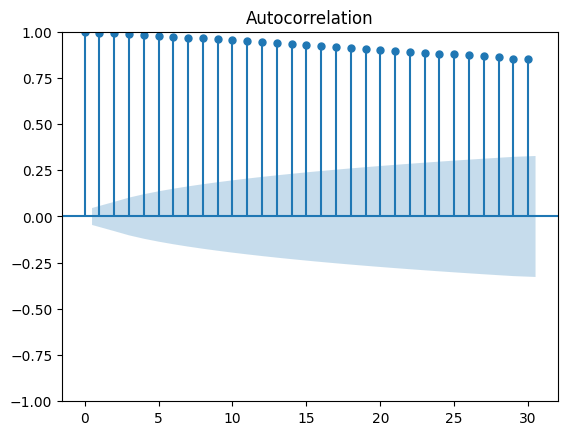

In [8]:
prices = data['Close']

# Plot autocorrelation up to 30 lags (you can change this number)
plot_acf(prices, lags=30)
plt.show()